In [1]:
import sys
import numpy as np
import keras

from keras import models, layers, optimizers, backend

import load_cifar10

%matplotlib inline
from IPython.core.pylabtools import figsize
import matplotlib.pyplot as plt

Using Theano backend.
/Library/Python/2.7/site-packages/theano/tensor/signal/downsample.py:6: UserWarning: downsample module has been moved to the theano.tensor.signal.pool module.
  "downsample module has been moved to the theano.tensor.signal.pool module.")


# Read in and inspect data

In [2]:
image_batches, label_batches = load_cifar10.Batches(include_labels=True)
train_image_batches = image_batches[:5]
train_label_batches = label_batches[:5]
train_images = np.concatenate(train_image_batches)
train_labels = np.concatenate(train_label_batches)
test_images = image_batches[5]
test_labels = label_batches[5]

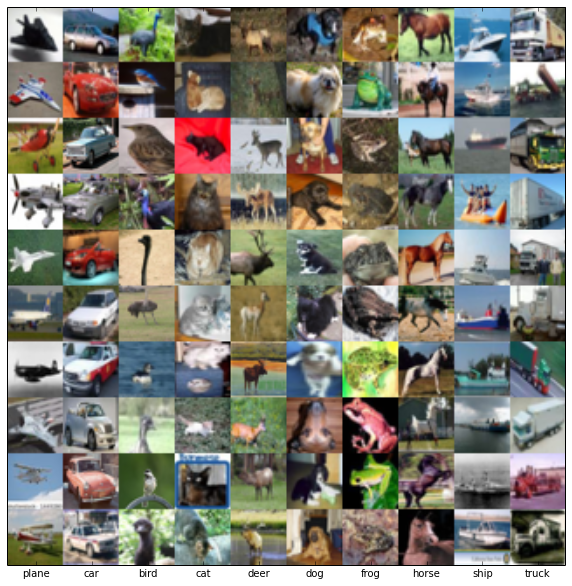

In [3]:
figsize(10, 10)
categories = ["plane", "car", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck"]
plt.imshow(np.concatenate(
    [train_images[train_labels == x][:10].reshape(320, 32, 3)
     for x in xrange(10)], axis=1))
plt.xticks(
    np.arange(10) * 32 + 16,
    categories)
plt.yticks([])
plt.show()

In [4]:
def GeneratorModel(z_size=64, initial_depth=256, output_size=32, output_channels=3):
    model = models.Sequential()
    model.add(layers.Dense(
        input_dim=z_size,
        output_dim=initial_depth * 4 * 4))
    model.add(layers.normalization.BatchNormalization())
    model.add(layers.Activation("relu"))
    model.add(layers.Reshape(dims=(initial_depth, 4, 4)))

    depth = initial_depth
    imsize = 4
    while imsize < output_size:
        imsize *= 2
        last_layer = imsize >= output_size
        depth = output_channels if last_layer else depth / 2
        model.add(layers.convolutional.UpSampling2D(size=(2, 2)))
        model.add(layers.convolutional.Convolution2D(
            depth, 3, 3,
            border_mode="same"))
        if not last_layer:
            model.add(layers.normalization.BatchNormalization())
        model.add(layers.Activation("sigmoid" if last_layer else "relu"))
    return model

In [5]:
def DiscriminatorModel(input_size=32, input_channels=3, initial_channels=64, leak=0.2):
    model = models.Sequential()
    model.add(layers.Convolution2D(
        initial_channels, 5, 5,
        subsample=(2, 2),
        input_shape=(input_channels, input_size, input_size),
        border_mode="valid"))
    model.add(layers.advanced_activations.LeakyReLU(leak))
    
    depth = initial_channels
    imsize = input_size / 2
    while imsize >= 8:
        imsize /= 2
        depth *= 2
        model.add(layers.convolutional.Convolution2D(
            depth, 3, 3,
            subsample=(2, 2),
            border_mode="valid"))
        model.add(layers.normalization.BatchNormalization())
        model.add(layers.advanced_activations.LeakyReLU(leak))

    model.add(layers.Flatten())
    model.add(layers.Dense(output_dim=1))
    model.add(layers.Activation("tanh"))
    return model

In [6]:
def DiscriminatorWrappingGenerator(gen, disc):
    model = models.Sequential()
    model.add(gen)
    disc.trainable = False
    model.add(disc)
    return model

In [14]:
def CompileNetworks(gen, disc, learning_rate=0.0002):
    disc_wrapping_gen = DiscriminatorWrappingGenerator(gen, disc)
    adam = optimizers.Adam(lr=learning_rate, beta_1=0.5, beta_2=0.999, epsilon=1e-8)

    print "Compiling Generator Alone..."
    sys.stdout.flush()
    gen.compile(loss="binary_crossentropy", optimizer=adam)
    
    print "Compiling Discriminator Wrapping Generator..."
    sys.stdout.flush()
    disc_wrapping_gen.compile(loss="binary_crossentropy", optimizer=adam)
    
    print "Compiling Discriminator Alone..."
    sys.stdout.flush()
    disc.trainable = True
    disc.compile(loss="binary_crossentropy", optimizer=adam)
    
    return gen, disc_wrapping_gen, disc


def Train(compiled_nets, train_im, batch_size=32, epochs=1, z_size=None):
    gen, disc_wrapping_gen, disc = compiled_nets
    z_size = z_size or gen.layers[0].input_shape[1]
    
    indices = np.arange(train_im.shape[0])
    for epoch in xrange(epochs):
        print "Starting Epoch {}...".format(epoch)
        sys.stdout.flush()
        np.random.shuffle(indices)
        batches = 0
        
        while (batches + 1) * batch_size < train_im.shape[0]:
            start_offset = batches * batch_size
            batches += 1
            stop_offset = batches * batch_size
            batch_im = np.rollaxis(train_im[start_offset:stop_offset], 3, 1) * 2 - 1
            
            # Forge
            noise = np.random.uniform(-1, 1, size=(batch_size, z_size))
            forgeries = generator.predict(noise)
            
            # Train Discriminator
            forgeries_and_real = np.concatenate([forgeries, batch_im])
            disc_targets = np.concatenate([np.zeros(batch_size), np.ones(batch_size)])
            disc_loss = float(disc.train_on_batch(forgeries_and_real, disc_targets)[0])
            
            # Train Generator
            gen_loss = float(disc_wrapping_gen.train_on_batch(noise, np.ones(batch_size))[0])
            
            # Report
            print "Epoch {e} Batch {b}: Generator Loss = {g:.6f}, Discriminator Loss = {d:.6f}".format(
                e=epoch, b=batches, g=gen_loss, d=disc_loss)
            sys.stdout.flush()
            plt.imshow((np.rollaxis(forgeries[0], 0, 3) + 1) / 2)
            plt.axis("off")
            plt.show()


In [15]:
generator = GeneratorModel()

In [16]:
discriminator = DiscriminatorModel()

In [17]:
for l in generator.layers:
    print l.name.rjust(20), str(l.input_shape).rjust(25), str(l.output_shape).rjust(25)

               dense                (None, 64)              (None, 4096)
  batchnormalization              (None, 4096)              (None, 4096)
          activation              (None, 4096)              (None, 4096)
             reshape              (None, 4096)         (None, 256, 4, 4)
        upsampling2d         (None, 256, 4, 4)         (None, 256, 8, 8)
       convolution2d         (None, 256, 8, 8)         (None, 128, 8, 8)
  batchnormalization         (None, 128, 8, 8)         (None, 128, 8, 8)
          activation         (None, 128, 8, 8)         (None, 128, 8, 8)
        upsampling2d         (None, 128, 8, 8)       (None, 128, 16, 16)
       convolution2d       (None, 128, 16, 16)        (None, 64, 16, 16)
  batchnormalization        (None, 64, 16, 16)        (None, 64, 16, 16)
          activation        (None, 64, 16, 16)        (None, 64, 16, 16)
        upsampling2d        (None, 64, 16, 16)        (None, 64, 32, 32)
       convolution2d        (None, 64, 32, 32)     

In [18]:
for l in discriminator.layers:
    print l.name.rjust(20), str(l.input_shape).rjust(25), str(l.output_shape).rjust(25)

       convolution2d         (None, 3, 32, 32)        (None, 64, 14, 14)
           leakyrelu        (None, 64, 14, 14)        (None, 64, 14, 14)
       convolution2d        (None, 64, 14, 14)         (None, 128, 6, 6)
  batchnormalization         (None, 128, 6, 6)         (None, 128, 6, 6)
           leakyrelu         (None, 128, 6, 6)         (None, 128, 6, 6)
       convolution2d         (None, 128, 6, 6)         (None, 256, 2, 2)
  batchnormalization         (None, 256, 2, 2)         (None, 256, 2, 2)
           leakyrelu         (None, 256, 2, 2)         (None, 256, 2, 2)
             flatten         (None, 256, 2, 2)              (None, 1024)
               dense              (None, 1024)                 (None, 1)
          activation                 (None, 1)                 (None, 1)


In [ ]:
compiled_nets = CompileNetworks(generator, discriminator)

Compiling Generator Alone...
Compiling Discriminator Wrapping Generator...
Compiling Discriminator Alone...


Starting Epoch 0...
Epoch 0 Batch 1: Generator Loss = 0.729810, Discriminator Loss = 0.687471


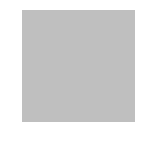

Epoch 0 Batch 2: Generator Loss = 0.753066, Discriminator Loss = 0.673916


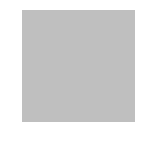

Epoch 0 Batch 3: Generator Loss = 0.778150, Discriminator Loss = 0.659087


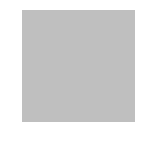

Epoch 0 Batch 4: Generator Loss = 0.804502, Discriminator Loss = 0.642193


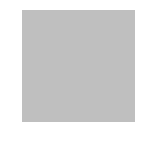

Epoch 0 Batch 5: Generator Loss = 0.829687, Discriminator Loss = 0.628495


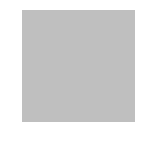

In [ ]:
figsize(2, 2)
Train(compiled_nets, train_images[:1000], batch_size=100)